<a href="https://colab.research.google.com/github/DarkTitan007/Facebook-Data-Sentimental-Analysis/blob/main/Facebook_Comments_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Facebook comments Sentiment analysis**

The aim of this notebook is to train and test a Neural Network to detect, if a Facebook comment is either positive or negative in nature, based on a sample of Facebook comments with attatched sentiment ratings.

In [79]:
fb = pd.read_csv('/fb_sentiment.csv')

**Exploring Data**

The data that we have chosen are Facebook-comments (FBPost) , with sentiments (Label) rated positive, negative or other. There are rows in the dataset, with an uneven distribution of sentiments.

In this section, some minor cleaning will take place.

In [80]:
fb.head()

,Unnamed: 0,FBPost,Label
0,0,Drug Runners and a U.S. Senator have somethin...,O
1,1,"Heres a single, to add, to Kindle. Just read t...",O
2,2,If you tire of Non-Fiction.. Check out http://...,O
3,3,Ghost of Round Island is supposedly nonfiction.,O
4,4,Why is Barnes and Nobles version of the Kindle...,N


In [81]:
# lower-casing the coloumn names
fb.columns = map(str.lower, fb.columns)

In [82]:
# checkin the shape of the DF
fb.shape

(1000, 3)

**Data Preparation**

Preparing the Facebook comments

In [83]:
#lowercasing the text and removing symbols though RegEx
import re
fb['fbpost'] = fb['fbpost'].apply(lambda x: x.lower())
fb['fbpost'] = fb['fbpost'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

With this Neural network, we want to predict, wether a comment is Positive (P) or Negative (N), so the comments with the sentiment labeled Other (O) is of no use to us, so it's removed from the dataset.

In [84]:
fb = fb[fb.label != "O"]

Now to tokenize the actual Facebook comments:

In [85]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(fb['fbpost'].values)
X = tokenizer.texts_to_sequences(fb['fbpost'].values)
X = pad_sequences(X)

**Preparing the labels**

Here the lables are checked after the removel of the "other" sentimented comments. Also some preperation to the algorithm, as preparing the test-, and training sets are done.

In [86]:
fb.label.value_counts()

P    641
N     79
Name: label, dtype: int64

In [87]:
Y = pd.get_dummies(fb['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(482, 203) (482, 2)
(238, 203) (238, 2)


**The Neural Network**

In this section, the algorithm is prepared with following features:

1. The model is Sequential
2. The model type is an LSTM model

In [88]:
embed_dim = 200
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 203, 200)          400000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 203, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                                 
 dense_2 (Dense)             (None, 2)                 402       
                                                                 
Total params: 721,202
Trainable params: 721,202
Non-trainable params: 0
_________________________________________________________________
None


In [89]:
# Here we train the model
batch_size = 32
hist = model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
16/16 - 20s - loss: 0.4484 - accuracy: 0.8610 - 20s/epoch - 1s/step
Epoch 2/7
16/16 - 17s - loss: 0.3048 - accuracy: 0.8963 - 17s/epoch - 1s/step
Epoch 3/7
16/16 - 17s - loss: 0.2650 - accuracy: 0.8983 - 17s/epoch - 1s/step
Epoch 4/7
16/16 - 18s - loss: 0.1993 - accuracy: 0.9315 - 18s/epoch - 1s/step
Epoch 5/7
16/16 - 17s - loss: 0.1143 - accuracy: 0.9585 - 17s/epoch - 1s/step
Epoch 6/7
16/16 - 18s - loss: 0.0887 - accuracy: 0.9647 - 18s/epoch - 1s/step
Epoch 7/7
16/16 - 17s - loss: 0.0435 - accuracy: 0.9917 - 17s/epoch - 1s/step


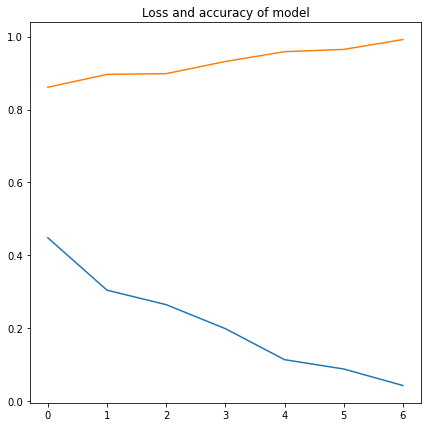

In [93]:
#Plotting a histogram over the 7 epocs and plotting the accuracy and loss
history = pd.DataFrame(hist.history)
plt.figure(figsize=(7,7));
plt.plot(history["loss"]);
plt.plot(history["accuracy"]);
plt.title("Loss and accuracy of model");
plt.show();


In [94]:
#Testing the model, and retrieveing score and accuracy:
score,acc = model.evaluate(X_test,Y_test)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

8/8 [==============================] - 2s 132ms/step - loss: 0.4590 - accuracy: 0.8866
score: 0.46
accuracy: 0.89


In [95]:
#now we validate for the models accuracy in predicting either a positive, or a negative score:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
x_test = X_test[:-validation_size]
y_test = Y_test[:-validation_size]

In [96]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    result = model.predict(X_validate[x].reshape(1,x_test.shape[1]),verbose = 2)[0]
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("positive_acc", pos_correct/pos_cnt*100, "%")
print("negative_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 364ms/epoch - 364ms/step
1/1 - 0s - 75ms/epoch - 75ms/step
1/1 - 0s - 74ms/epoch - 74ms/step
1/1 - 0s - 86ms/epoch - 86ms/step
1/1 - 0s - 73ms/epoch - 73ms/step
1/1 - 0s - 80ms/epoch - 80ms/step
1/1 - 0s - 74ms/epoch - 74ms/step
1/1 - 0s - 74ms/epoch - 74ms/step
1/1 - 0s - 84ms/epoch - 84ms/step
1/1 - 0s - 77ms/epoch - 77ms/step
1/1 - 0s - 75ms/epoch - 75ms/step
1/1 - 0s - 78ms/epoch - 78ms/step
1/1 - 0s - 72ms/epoch - 72ms/step
1/1 - 0s - 75ms/epoch - 75ms/step
1/1 - 0s - 76ms/epoch - 76ms/step
1/1 - 0s - 75ms/epoch - 75ms/step
1/1 - 0s - 81ms/epoch - 81ms/step
1/1 - 0s - 80ms/epoch - 80ms/step
1/1 - 0s - 77ms/epoch - 77ms/step
1/1 - 0s - 81ms/epoch - 81ms/step
1/1 - 0s - 71ms/epoch - 71ms/step
1/1 - 0s - 72ms/epoch - 72ms/step
1/1 - 0s - 78ms/epoch - 78ms/step
1/1 - 0s - 73ms/epoch - 73ms/step
1/1 - 0s - 73ms/epoch - 73ms/step
1/1 - 0s - 78ms/epoch - 78ms/step
1/1 - 0s - 78ms/epoch - 78ms/step
1/1 - 0s - 75ms/epoch - 75ms/step
1/1 - 0s - 74ms/epoch - 74ms/step
1/1 - 0s - 7

In [97]:
#now testing  on a random sample from the Facebook comments on Kindle's page:
cmnt = ['your customer service is the absolute worst i now have a mess of books on my kindle']
#vectorizing the comment
cmnt = tokenizer.texts_to_sequences(cmnt)
cmnt = pad_sequences(cmnt, maxlen=203, dtype='int32', value=0)
print(cmnt)
sentiment = model.predict(cmnt,batch_size=2,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  51 510 674  12   2 895   1  69  11   6
   13  16  20   3   4]]
1/1 - 0s - 72ms/epoch - 72ms/step
positive


What went wrong?

Our sample size for the training-, and test set was in fact quite small (under 1000 comments), and the proportion of negative to positive comments was skewed about 1 to 9. So the algorithm was not really optimized on the basis of our data. This is the reason for the algorithm choosing the wrong sentiment in the sample-test above